<a href="https://www.kaggle.com/code/averma111/simple-pk-fog?scriptVersionId=125314690" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')


In [3]:
tdcsfog_path='/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog'

In [4]:
## https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65
def reduce_memory_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024 ** 2 
    print("Memory usage became: ",mem_usg," MB")
    
    return df

In [5]:
tdcsfog_list =[]
for file_name in os.listdir(tdcsfog_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(tdcsfog_path, file_name)
        file = pd.read_csv(file_path)
        tdcsfog_list.append(file)

In [6]:
tdcsfog = pd.concat(tdcsfog_list, axis = 0)


In [7]:
tdcsfog=reduce_memory_usage(tdcsfog)

Memory usage of dataframe is 431.07 MB
Memory usage became:  141.4452667236328  MB


In [8]:
def summary(text, df):
    print(f'{text} shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['null'] = df.isnull().sum()
    summ['unique'] = df.nunique()
    summ['min'] = df.min()
    summ['median'] = df.median()
    summ['max'] = df.max()
    summ['mean'] = df.mean()
    summ['std'] = df.std()
    return summ

In [9]:
summary('tdcsfog',tdcsfog)

tdcsfog shape: (7062672, 7)


,dtypes,null,unique,min,median,max,mean,std
Time,int32,0,97077,0.000000,4310.000000,97076.000000,9289.467297,13998.925696
AccV,float16,0,4080,-35.531250,-9.367188,20.906250,NaN,0.000000
AccML,float16,0,30511,-26.171875,-0.172241,27.484375,NaN,0.000000
AccAP,float16,0,27751,-47.843750,1.987305,30.343750,NaN,0.000000
StartHesitation,int8,0,2,0.000000,0.000000,1.000000,0.043155,0.203206
Turn,int8,0,2,0.000000,0.000000,1.000000,0.237698,0.425673
Walking,int8,0,2,0.000000,0.000000,1.000000,0.029428,0.169002


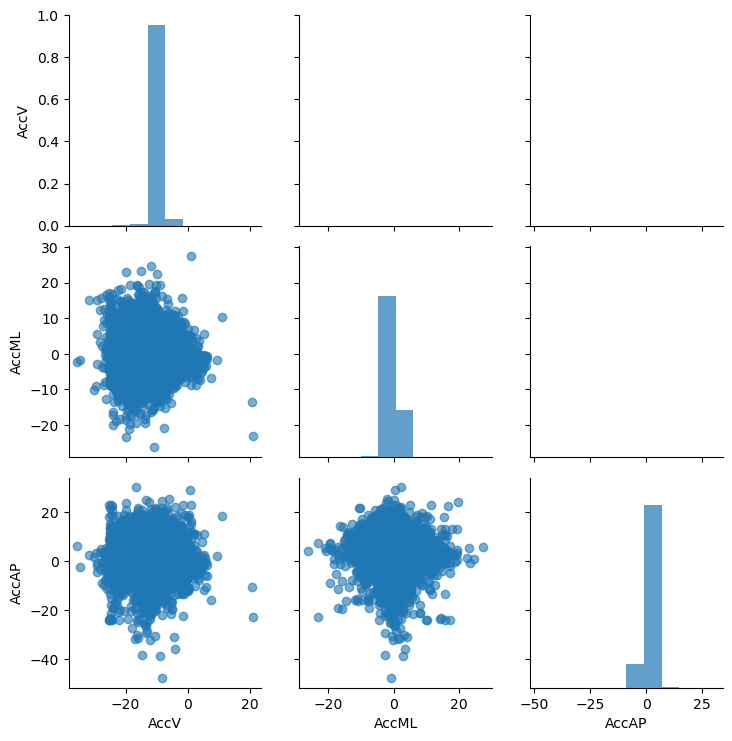

In [10]:
g = sns.PairGrid(tdcsfog[['AccV', 'AccML', 'AccAP']])
g.map_lower(plt.scatter, alpha = 0.6)
g.map_diag(plt.hist, alpha = 0.7)

In [11]:
X = tdcsfog.iloc[:, 1:4]  
y1 = tdcsfog['StartHesitation']  
y2 = tdcsfog['Turn']  
y3 = tdcsfog['Walking'] 

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,mean_squared_log_error

X_train, X_val, y1_train, y1_val = train_test_split(X, y1, test_size = 0.2, random_state = 52)
X_train, X_val, y2_train, y2_val  = train_test_split(X, y2, test_size = 0.2, random_state = 52)
X_train, X_val, y3_train, y3_val = train_test_split(X, y3, test_size = 0.2, random_state = 52)

In [13]:
from catboost import  CatBoostRegressor

# Create three separate logistic regression models.
model1 = CatBoostRegressor()
model2 = CatBoostRegressor()
model3 = CatBoostRegressor()

# Train the models on the training data.
model1.fit(X_train, y1_train)
model2.fit(X_train, y2_train)
model3.fit(X_train, y3_train)

# Evaluate the models on the test data.
print('Accuracy for StartHesitation:', model1.score(X_val, y1_val))
print('Accuracy for Turn:', model2.score(X_val, y2_val))
print('Accuracy for Walking:', model3.score(X_val, y3_val))

Learning rate set to 0.160326
0:	learn: 0.2019526	total: 582ms	remaining: 9m 41s
1:	learn: 0.2009460	total: 969ms	remaining: 8m 3s
2:	learn: 0.2001895	total: 1.34s	remaining: 7m 25s
3:	learn: 0.1995976	total: 1.73s	remaining: 7m 10s
4:	learn: 0.1991366	total: 2.11s	remaining: 7m
5:	learn: 0.1987893	total: 2.48s	remaining: 6m 50s
6:	learn: 0.1985137	total: 2.86s	remaining: 6m 45s
7:	learn: 0.1983043	total: 3.26s	remaining: 6m 44s
8:	learn: 0.1980966	total: 3.63s	remaining: 6m 39s
9:	learn: 0.1979638	total: 4.01s	remaining: 6m 36s
10:	learn: 0.1978128	total: 4.4s	remaining: 6m 35s
11:	learn: 0.1977015	total: 4.78s	remaining: 6m 33s
12:	learn: 0.1974457	total: 5.15s	remaining: 6m 30s
13:	learn: 0.1973451	total: 5.53s	remaining: 6m 29s
14:	learn: 0.1971644	total: 5.91s	remaining: 6m 27s
15:	learn: 0.1970845	total: 6.3s	remaining: 6m 27s
16:	learn: 0.1970322	total: 6.67s	remaining: 6m 25s
17:	learn: 0.1968818	total: 7.05s	remaining: 6m 24s
18:	learn: 0.1968319	total: 7.42s	remaining: 6m 22s

In [16]:
from sklearn.metrics import classification_report

y1_pred = model1.predict(X_val)
y2_pred = model2.predict(X_val)
y3_pred = model3.predict(X_val)

print(f'Classification Report for StartHesitation:{classification_report(y1_val, y1_pred)}')

print(f'Classification Report for Turn:{classification_report(y2_val, y2_pred)}')

print(f'Classification Report for Walking: {classification_report(y3_val, y3_pred)}')


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
tdcsfog_test_path = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test/tdcsfog'
tdcsfog_test_list = []
for file_name in os.listdir(tdcsfog_test_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(tdcsfog_test_path, file_name)
        file = pd.read_csv(file_path)
        file['Id'] = file_name[:-4] + '_' + file['Time'].apply(str)
        tdcsfog_test_list.append(file)
tdcsfog_test = pd.concat(tdcsfog_test_list, axis = 0)
tdcsfog_test

In [ ]:
defog_test_path = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test/defog'
defog_test_list = []
for file_name in os.listdir(defog_test_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(defog_test_path, file_name)
        file = pd.read_csv(file_path)
        file['Id'] = file_name[:-4] + '_' + file['Time'].apply(str)
        defog_test_list.append(file)

defog_test = pd.concat(defog_test_list, axis = 0)
defog_test

In [ ]:
tdcsfog_test = reduce_memory_usage(tdcsfog_test)

In [ ]:
defog_test = reduce_memory_usage(defog_test)

In [ ]:
test = pd.concat([tdcsfog_test, defog_test], axis = 0).reset_index(drop = True)
test

In [ ]:
model = CatBoostRegressor()
test_X = test.iloc[:, 1:4]
y1 = tdcsfog['StartHesitation']  
y2 = tdcsfog['Turn']  
y3 = tdcsfog['Walking'] 
model.fit(test_X,y1)
model.fit(test_X,y2)
model.fit(test_X,y3)

pred_y1 = model.predict(test_X)
pred_y2 = model.predict(test_X)
pred_y3 = model.predict(test_X)

test['StartHesitation'] = pred_y1 # target variable for StartHesitation
test['Turn'] = pred_y2 # target variable for Turn
test['Walking'] = pred_y3 # target variable for Walking

test

In [ ]:
submission = test.iloc[:, 4:].fillna(0.0)
submission.to_csv("submission.csv", index = False)